# Data Augmentations (DA):

**What is DA?**

* DA is a set of techniques to increase amount of data used in training. These techniques varies from basic to advanced levels. 
* Some of the basic Vision DA's are rotaion, translation, blurring, brightness and contrast adjustments etc. 
* Then there are moderate level DA's such as Mixup, Cutout, CutMix, GridMask etc.
* Advanced level DA techniques are FeatMatch, MomentExchange, and GAN's. These are much more complex and technical than rest of two DA's.
* [Transforms](https://pytorch.org/vision/stable/transforms.html) and [albumentations
](https://github.com/albumentations-team/albumentations) are two mostly used libraries for Vision DA's.

**Why DA?**

* **Data** lies at the center of the any Deep Learning Task. The more Qualitative data you have, more wiser and accurate your model will be.
* But Collecting and labeling the huge data is an arduous task. It requires manual effort and can be costly and time consuming sometimes depending on the task.
* Here **DA comes to the rescue**, DA is like the proper utilization of the Existing Data and making most out of it. A variety of studies have shown that DA can increase the model performance by a good margin.
* In technical terms, **DA works as a Regularizer and prevents model overfitting**.

## Goal

1) Implement the following DA techniques from the Scratch in Pytorch: (**This Notebook**)

* Cutout
* Mixup
* CutMix
* AugMix
* GridMask

2) How to use these DA's during model training. (Train on [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification))

3) Analyze the Impact of these techniques on the Model Performance.

In [1]:
# Import useful modules.
import numpy as np
import torch
import torch.nn as nn

## 1. Cutout

* Cutout randomly masks the square region of the input images during training.
* According to the author, The size of the cutout region is more important hyperparameter than the shape. So for simplicity, the author uses squared region.
* At the time of the implementation, it yielded state-of-the-art performance on CIFAR-10, 100, and SVHN Datasets.

**References**
* [Improved Regularization of Convolutional Neural Networks with Cutout](https://arxiv.org/abs/1708.04552)
* [GitHub Cutout](https://github.com/uoguelph-mlrg/Cutout/blob/master/train.py)

In [2]:
class Cutout(object):
    
    '''Randomly masks out one or more patches from image.'''
    '''
    Inputs : 
    1) n_holes : # of holes to be cutout from images.
    2) length : Dimension of the squared patches to be cutout.
    3) margin_length : For random size Cutouts, Shape of the cutouts will
                       be randomly chosen between [len - margin_length, len + margin_length]
    '''
    
    def __init__(self,
                 n_holes,
                 length,
                 margin_length = None,
                ):
        self.n_holes = n_holes
        self.length = length
        self.margin_length = margin_length
        
    def __call__(self, img):
        
        h = img.size(1)
        w = img.size(2)
        
        mask = np.ones((h, w), np.float32)
        
        for n in range(self.n_holes):
            y = np.random.randint(0, h)
            x = np.random.randint(0, w)
            
            if self.margin_length is not None:
                self.length += np.random.randint(-self.margin_length, self.margin_length)
            
            y1 = np.clip(y - self.length//2, 0, h)
            x1 = np.clip(x - self.length//2, 0, w)
            y2 = np.clip(y + self.length//2, 0, h)
            x2 = np.clip(x + self.length//2, 0, w)
            
            mask[y1:y2, x1:x2] = 0.
            
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        
        return img

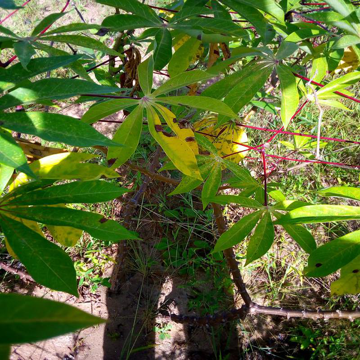

In [3]:
from PIL import Image
from torchvision import transforms

# Read Image
img = Image.open('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
img = img.resize((360, 360))
img

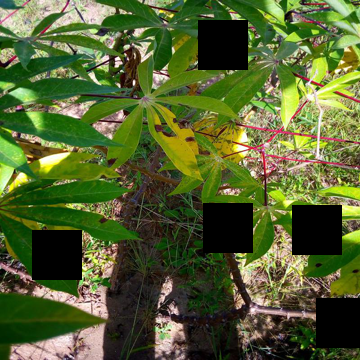

In [4]:
## Constant-Size Cutouts.

# Convert Image to Tensor
convert_tensor = transforms.ToTensor()
tensor_img = convert_tensor(img)

# Perform Cutout
cutout = Cutout(5, 50) # 5 holes each of size 50.
aug_img = cutout(tensor_img)

# Convert the Tensor back to Image for visualization Purpose.
convert_img = transforms.ToPILImage()
aug_img = convert_img(aug_img)
aug_img

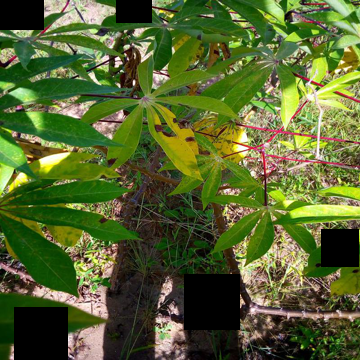

In [8]:
## Random-Size Cutouts.

# Convert Image to Tensor
convert_tensor = transforms.ToTensor()
tensor_img = convert_tensor(img)

# Perform Cutout
cutout = Cutout(5, 50, 20) # 5 holes of the sizes between [30, 70]
aug_img = cutout(tensor_img)

# Convert the Tensor back to Image for visualization Purpose.
convert_img = transforms.ToPILImage()
aug_img = convert_img(aug_img)
aug_img

## 2. Mixup

* Large Deep neural nets exhibits undesirable behaviours such as Memorization and Sensitivity to adversial examples.
* Mixup reduces the memorization of the corrupt labels and increase the robustness to adversial examples.
* Mixup is a simple technique, It basically takes linear combination of the inputs and outputs and feeds it to the network during training as follows:

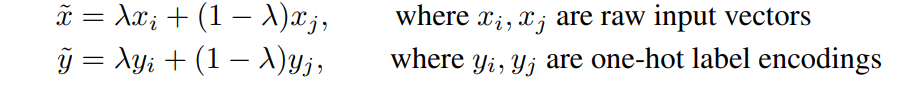

 where $$\lambda  \in [0, 1], \\ \lambda \thicksim Beta(\alpha, \alpha)$$ 

According to the [paper](https://arxiv.org/abs/1710.09412), mixup improves the generalization of the SOTA models and improve the performance by a good margin.

**References:**

* [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
* [GitHub mixup](https://github.com/facebookresearch/mixup-cifar10)

In [4]:
class Mixup(object):
    
    '''alpha : Controls the mixup distribution, should be >= 0
               For uniform Distribution of lambda, set alpha = 1
    '''
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def __call__(self, batch, targets, use_cuda=False):
        
        # Sample lambda from Beta(alpha, alpha)
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
            
        batch_size = batch.size()[0]
        
        if use_cuda:
            index = torch.randperm(batch_size).cuda()
        else:
            index = torch.randperm(batch_size)
            
        mixed_x = lam * batch + (1 - lam) * batch[index, :] # Mixup
        y_a, y_b = targets, targets[index]
        
        return mixed_x, y_a, y_b, lam

In [5]:
from matplotlib import pyplot as plt

# Helper Fxn for Visualization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader 
import torchvision

TRAIN_DATA_PATH = "../input/cat-and-dog//"

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

train_data = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = DataLoader(train_data, batch_size=4, shuffle=True)

In [12]:
batch, target = next(iter(train_data_loader))

# Mixup
mixup = Mixup(5)
mixed_x, y_a, y_b, lam = mixup(batch, target)
y_a, y_b

(tensor([1, 0, 0, 1]), tensor([1, 0, 1, 0]))

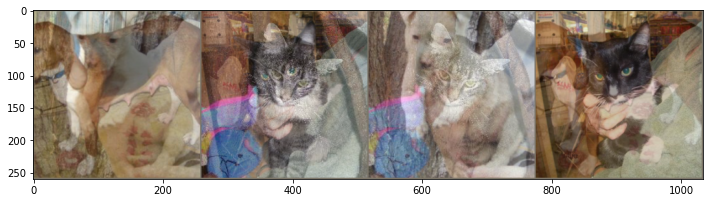

In [13]:
out = torchvision.utils.make_grid(mixed_x)
imshow(out)

## 3. CutMix

* Feature removal regularization techniques such as Dropout, Cutout, Random Erasing, etc have contributed in generalizing the model.
* However they also leads to information loss and data inefficiency since a part of the input (or feature) is set to zero.
* In order to tackle this issue, the author proposed [CutMix](https://arxiv.org/abs/1905.04899). CutMix randomly cuts the parts of the input and paste it to the another image, targets are also propotionaly mixed.
* According to the Author, CutMix outperforms Cutout, Dropout, Mixup etc on Classification, Localization, and Detection tasks.



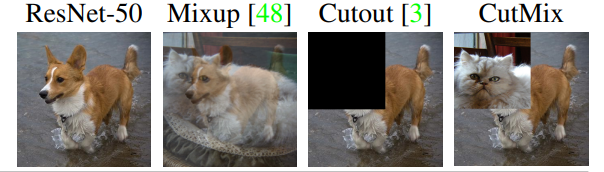

**References:**

* [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/abs/1905.04899)
* [GitHub CutMix](https://github.com/clovaai/CutMix-PyTorch/blob/master/train.py)

In [7]:
class CutMix(object):
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def __call__(self, batch, targets, use_cuda=False):
        
        # Sample lambda from Beta(alpha, alpha)
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
            
        batch_size = batch.size()[0]
        
        if use_cuda:
            index = torch.randperm(batch_size).cuda()
        else:
            index = torch.randperm(batch_size)
        
        y_a, y_b = targets, targets[index]
        
        # Choose random bbox
        bbx1, bby1, bbx2, bby2 = self._rand_bbox(batch.size(), lam)
        
        # CutMix
        batch[:, :, bbx1:bbx2, bby1:bby2] = batch[index, :, bbx1:bbx2, bby1:bby2] #CutMix
        
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (batch.size()[-1] * batch.size()[-2]))
        
        return batch, y_a, y_b, lam
    
    def _rand_bbox(self, size, lam):
        
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = (W * cut_rat).astype(int)
        cut_h = (H * cut_rat).astype(int)

        # uniform
        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

In [22]:
batch, target = next(iter(train_data_loader))

# Cutmix
cutmix = CutMix(5)
cutmixed_x, y_a, y_b, lam = cutmix(batch, target)
y_a, y_b

(tensor([1, 0, 1, 1]), tensor([1, 1, 0, 1]))

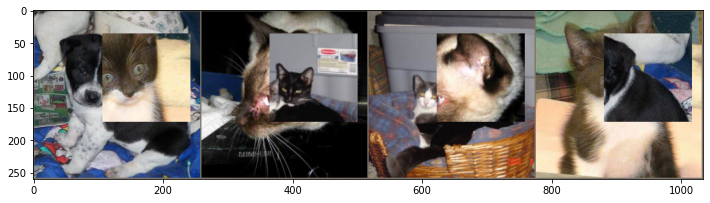

In [23]:
out = torchvision.utils.make_grid(cutmixed_x)
imshow(out)

## 4. AugMix

* Deep neural networks performs well when the training and test data have identical Distributions.
* However the accuracy gain drops drastically when test-set distribution shifts from training set. For ex. Imagenet-C (Corrupted Imagenet Dataset) 
* To tackle this issue, AugMix **randomly mixes variety of Data Augmentaions** in such a way that Model doesn't memorize any particular augmentation (or chain of augmentations).
* The [author](https://arxiv.org/abs/1912.02781) also proposed **JSD (Jenson Shannon Divergence) loss** which impels model to be stable, consistent, and insensitive across diverse range of inputs.
* AugMix outperforms all other DA techniques on Imagenet-C, CIFAR-C dataset by a large margin.

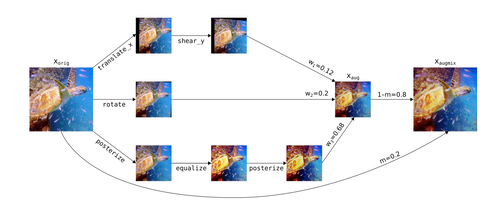


**References:**

* [AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty](https://arxiv.org/abs/1912.02781)
* [GitHub AugMix](https://github.com/google-research/augmix/blob/master/augmentations.py)


In [214]:
AUGMENTATIONS = [
    transforms.RandomAutocontrast(p=1.0),
    transforms.RandomEqualize(p=1.0),
    transforms.RandomPosterize(bits=4, p=1.0),
    transforms.RandomRotation(degrees=30,
                              interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomSolarize(threshold=128, p=1.0),
    transforms.RandomAffine(degrees = 0,
                            shear=(-0.3, 0.3, 0, 0)
                           ), # Shear in X-Dir.
    transforms.RandomAffine(degrees = 0,
                            shear=(0, 0, -0.3, 0.3)
                           ), # Shear in Y-Dir.
    transforms.RandomAffine(degrees=0, 
                            translate=(0.34, 0),
                            interpolation=transforms.InterpolationMode.BILINEAR
                           ), # Translation in X-Dir.
    transforms.RandomAffine(degrees=0,
                            translate=(0, 0.34),
                            interpolation=transforms.InterpolationMode.BILINEAR
                           ), # Translation in Y-Dir.
    transforms.ColorJitter(brightness=(0.75, 1.25)), # Brightness
    transforms.ColorJitter(contrast=(0.75, 1.25)), # Contrast
    transforms.ColorJitter(saturation=(0.75, 1.25)), # Saturation
]

#------------------------------------------------------------------

# Preprocess
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

PREPROCESS = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]
)

In [37]:
class AugMix(object):
    
    """Perform AugMix augmentations and compute mixture.
  Args:
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
  Returns:
    mixed: Augmented and mixed image.
  """
    
    def __init__(self, 
                 width = 3,
                 depth = -1, 
                 alpha = 1.0,
                 preprocess = PREPROCESS
                ):
        self.width = width
        self.depth = depth
        self.alpha = alpha
        self.preprocess = preprocess
        
    def __call__(self, img):
        
        ws = np.float32(np.random.dirichlet([self.alpha] * self.width))
        m = np.float32(np.random.beta(self.alpha, self.width))
        
        mix = torch.zeros_like(self.preprocess(img))
        
        for i in range(self.width):
            img_aug = img.copy()
            depth = self.depth if self.depth > 0 else np.random.randint(1, 4)
            for _ in range(depth):
                op = np.random.choice(AUGMENTATIONS)
                img_aug = op(img_aug)
            mix += ws[i]* self.preprocess(img_aug)
            
        mixed = ((1-m) * self.preprocess(img)) + (m * mix)
        
        return mixed

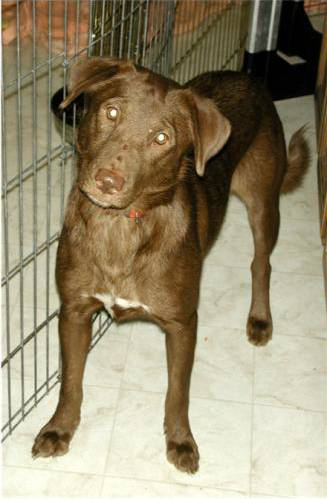

In [33]:
pil_img = Image.open('../input/cat-and-dog/training_set/training_set/dogs/dog.1.jpg')
pil_img

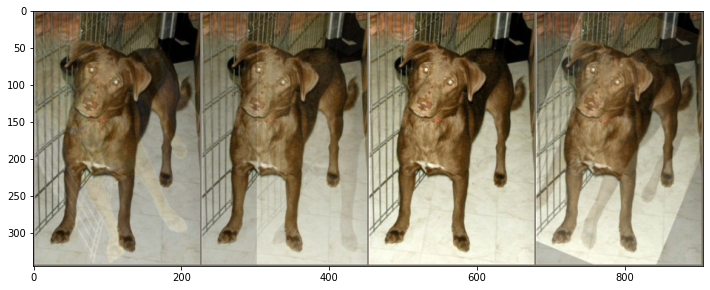

In [50]:
# AugMix
augmix = AugMix()
augmixed_x = [augmix(pil_img) for _ in range(4)]

out = torchvision.utils.make_grid(augmixed_x)
imshow(out)

## 5. GridMask

* GridMask can be considered as a good balance between Cutout and HaS (Hide and Seek).
* In Cutout, we randomly remove a big continous portion of the image. In HaS, we randomly remove multiple portions from the image.
* Both of these cases may lead to Complete or No removal of the object from image. In both of these extreme cases, it doesn't add anything to model robustness.
* Unlike Cutout and HaS, Gridmask removes **uniformaly distributed squared patches** from the images that has comparatively less probability of Complete or No removal of the object from the image.

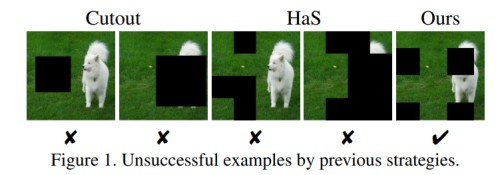

* According to the paper, GridMask has more probability of the success than Cutout and HaS.

**References:**

* [GridMask Data Augmentation](https://arxiv.org/abs/2001.04086)
* [GitHub GridMask](https://github.com/dvlab-research/GridMask)

In [233]:
class GridMask(object):
    
    '''Perform GridMask Data Augmentation.
    Args:
       num_grids : number of grids If -1 is given it will randomly 
                   select n between (2, 5).
       grid_size : size of the each removed region. If -1 is given it will
                   randomly select a squared region between [Image_shape//8, Image_shape//4]  
    '''
    def __init__(self,
                num_grids = -1,
                grid_size = -1,
                #rotate = 2
                ):
        super(GridMask, self).__init__()
        self.num_grids = num_grids
        self.grid_size = grid_size
        #self.rotate = rotate
        
    def __call__(self, img):
        num_grids = self.num_grids if self.num_grids > 0 else np.random.randint(2, 5)
        grid_size = self.grid_size if self.grid_size > 0 else np.random.randint(img.size()[-1]/8, img.size()[-1]/4)
        
        #print(num_grids, grid_size)
        mask = np.ones((img.size()[-1], img.size()[-1]), np.float32)
        
        # Choose starting point.
        start_x = np.random.randint(0, (img.size()[-1]-grid_size)//num_grids)
        start_y = np.random.randint(0, (img.size()[-1]-grid_size)//num_grids)
        temp = start_x
        
        for i in range(num_grids):
            start_x = temp
            for j in range(num_grids):
                mask[start_y : start_y + grid_size, start_x : start_x + grid_size] = 0.
                start_x += 2*grid_size
            start_y += 2*grid_size
        
        #r = np.random.randint(self.rotate)
        #mask = Image.fromarray(np.uint8(mask))
        #mask = mask.rotate(r)
        #mask = np.asarray(mask)
        
        mask = torch.from_numpy(mask).float()
        
        mask = mask.expand_as(img)
        img = img * mask 

        return img

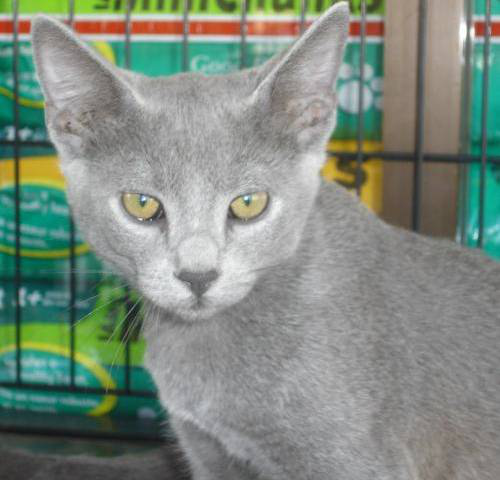

In [250]:
pil_img = Image.open('../input/cat-and-dog/training_set/training_set/cats/cat.1013.jpg')
pil_img

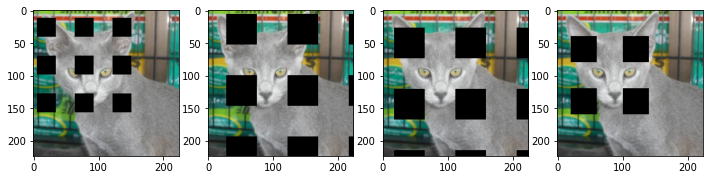

In [251]:
# Preprocess
PREPROCESS = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
    ]
)

tensor_img = PREPROCESS(pil_img)

gridmask = GridMask()
gridmasked_x = [gridmask(tensor_img) for _ in range(4)]

# Convert the Tensor back to Image for visualization Purpose.
convert_img = transforms.ToPILImage()

f, ax = plt.subplots(1, 4, figsize=(12, 12))

for i in range(4):
    ax[i].imshow(convert_img(gridmasked_x[i]))

# To be Continued....

* How to use these DA's during model training. (Train on [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification))

* Analyze the Impact of these techniques on the Model Performance.

-----------------------------------------------------------------------------------